In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
        
imgs.shape, bboxes.shape

((50000L, 16L, 16L), (50000L, 2L, 4L))

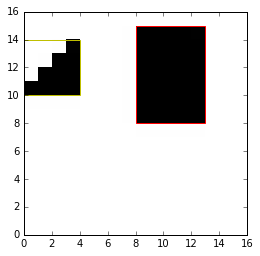

In [3]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))

In [4]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000L, 256L), -4.0834557957225569e-17, 1.0000000000000016)

In [5]:
# TODO: We use binary classification here - for multiple classes, convert classes to one-hot vectors.
y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

(50000L, 10L)

In [6]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

Using Theano backend.


In [8]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    w_I = max(w_I, 0)  # set w_I and h_I zero if there is no intersection
    h_I = max(h_I, 0)
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious = np.zeros((len(flipped_train_y), num_epochs))
dists = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print 'Epoch', epoch
    model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        if mse_flipped < mse:  # using iou or dist here leads to similar results
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            ious[i, epoch] = iou_flipped / 2.
            dists[i, epoch] = dist_flipped / 2.
        else:
            ious[i, epoch] = iou / 2.
            dists[i, epoch] = dist / 2.
            
    print 'Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.)
    print 'Mean IOU: {}'.format(np.mean(ious[:, epoch]))
    print 'Mean dist: {}'.format(np.mean(dists[:, epoch]))
    print

Epoch 0
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
5s - loss: 0.1568 - val_loss: 0.0559
Flipped 19200.0 training samples (48.0 %)
Mean IOU: 0.242985636173
Mean dist: 0.197557964071

Epoch 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
5s - loss: 0.0557 - val_loss: 0.0501
Flipped 10275.0 training samples (25.6875 %)
Mean IOU: 0.279607567133
Mean dist: 0.180107625927

Epoch 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
5s - loss: 0.0492 - val_loss: 0.0484
Flipped 7191.0 training samples (17.9775 %)
Mean IOU: 0.319445985247
Mean dist: 0.160972388048

Epoch 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
4s - loss: 0.0442 - val_loss: 0.0493
Flipped 4605.0 training samples (11.5125 %)
Mean IOU: 0.362110983162
Mean dist: 0.142787179212

Epoch 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
4s - loss: 0.0397 - val_loss: 0.0514
Flipped 2731.0 training samples (6.8275 %)
Mean IOU: 0.398454722176
Mean dist: 0.12687690291

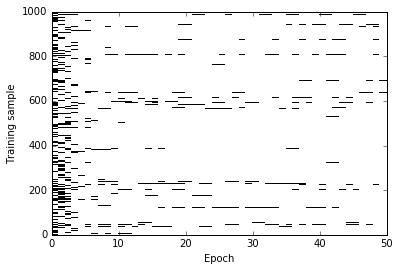

In [9]:
plt.pcolor(flipped[:1000], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0, 1)

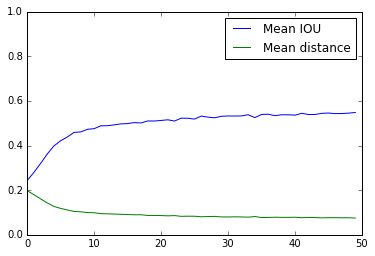

In [10]:
plt.plot(np.mean(ious, axis=0), label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists, axis=0), label='Mean distance')  # relative to image size
plt.legend()
plt.ylim(0, 1)

In [11]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000L, 2L, 4L), (10000L, 2L, 1L))

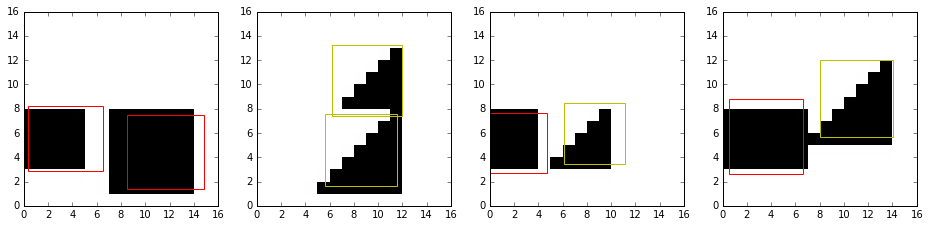

In [31]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

# plt.savefig('plots/bw-two-rectangles-or-triangles4.png', dpi=300)